# Visualización de Información en Python

> **Autor** \
> Eduardo Graells-Garrido \
> Instituto de Data Science UDD \
> Telefónica I+D Chile \
> egraells@udd.cl \
> @carnby

## Sesión 5: Redes en un Mapa

> **Caso de Estudio** \
> Data Set: Encuesta de Viajes (Origen-Destino) de Santiago, 2012 \
> Data Set: [Mapas del Censo](http://www.censo2017.cl/servicio-de-mapas/), 2017 \
> Diplomado en Data Science UDD

### Preámbulo

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import normalize
# incorporamos networkx! :)
import networkx as nx

%matplotlib inline
sns.set(context='notebook', font='Fira Sans', style='white', palette='plasma')

In [3]:
def decode_column(df, fname, col_name, index_col='Id', value_col=None, sep=';', encoding='utf-8', index_dtype=np.float64):
    '''
    param :df: DataFrame del que leeremos una columna.
    param :fname: nombre del archivo que contiene los valores a decodificar.
    param :col_name: nombre de la columna que queremos decodificar.
    param :index_col: nombre de la columna en el archivo @fname que tiene los índices que codifican @col_name
    param :value_col: nombre de la columna en el archivo @fname que tiene los valores decodificados
    param :sep: carácter que separa los valores en @fname. 
    param :encoding: identificación del _character set_ que utiliza el archivo. Usualmente es utf-8, si no funciona,
                     se puede probar con iso-8859-1.
    '''
    if value_col is None:
        value_col = 'value'
        
    values_df = pd.read_csv(fname, sep=sep, index_col=index_col, names=[index_col, value_col], header=0,
                            dtype={index_col: index_dtype}, encoding=encoding)
    
    src_df = df.loc[:,(col_name,)]
    
    return src_df.join(values_df, on=col_name)[value_col]

def normalize_rows(df):
    df = pd.DataFrame(normalize(df, norm='l1'), index=df.index, columns=df.columns)
    return df

def normalize_columns(df):
    df = pd.DataFrame(normalize(df, norm='l1', axis=0), index=df.index, columns=df.columns)
    return df

def z_score_columns(df):
    return df.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

---

## Carga de Datos

Noten que ahora tenemos una variable `path_maps`, que contiene los ficheros con información geográfica en formato `shapefile`.

In [4]:
path = './EOD_STGO'

In [5]:
path_maps = './maps'

### Viajes

Primero, carguemos los datos que hemos trabajado en los notebooks anteriores.

In [6]:
viajes = (pd.read_csv(path + '/viajes.csv', sep=';', decimal=',', index_col='Viaje')
          .join(pd.read_csv(path + '/ViajesDifusion.csv', sep=';', index_col='Viaje'))
          .join(pd.read_csv(path + '/DistanciaViaje.csv', sep=';', index_col='Viaje')))

viajes['ModoDifusion'] = decode_column(viajes, path + '/Tablas_parametros/ModoDifusion.csv', 'ModoDifusion', encoding='latin-1',
                                       index_col='ID')
viajes['Proposito'] = decode_column(viajes, path + '/Tablas_parametros/Proposito.csv', col_name='Proposito')
viajes['SectorOrigen'] = decode_column(viajes, path + '/Tablas_parametros/Sector.csv', 
                                       col_name='SectorOrigen', index_col='Sector', value_col='Nombre', sep=';')
viajes['SectorDestino'] = decode_column(viajes, path + '/Tablas_parametros/Sector.csv', 
                                       col_name='SectorDestino', index_col='Sector', value_col='Nombre', sep=';')
viajes['ComunaOrigen'] = decode_column(viajes, path + '/Tablas_parametros/Comunas.csv', 'ComunaOrigen', 
                                       value_col='Comuna', sep=',')
viajes['ComunaDestino'] = decode_column(viajes, path + '/Tablas_parametros/Comunas.csv', 'ComunaDestino', 
                                       value_col='Comuna', sep=',')
viajes['Periodo'] = decode_column(viajes, path + '/Tablas_parametros/Periodo.csv', 'Periodo', 
                                  sep=';', value_col='Periodos')

# descartamos sectores que no sean relevantes en los orígenes y destinos de los viajes
viajes = viajes[(viajes['SectorOrigen'] != 'Exterior a RM') 
                & (viajes['SectorDestino'] != 'Exterior a RM')
                & (viajes['SectorOrigen'] != 'Extensión Sur-Poniente') 
                & (viajes['SectorDestino'] != 'Extensión Sur-Poniente')
                & pd.notnull(viajes['SectorOrigen'])
                & pd.notnull(viajes['SectorDestino'])
                # también descartamos viajes que hayan sido imputados en la encuesta
                & (viajes['Imputada'] == 0)
                # y finalmente descartamos viajes cuya distancia indique que son viajes cortísimos o bien demasiado largos para el tamaño de la ciudad
                & (viajes['DistManhattan'].between(500, 35000))]

print(len(viajes))

77383


In [7]:
from collections import defaultdict

propositos_agregados = defaultdict(lambda: 'Otro')

propositos_agregados.update({
    'Al estudio': 'Estudio',
    'Al trabajo': 'Trabajo',
    'Por estudio': 'Estudio',
    'Por trabajo': 'Trabajo',
    'volver a casa': 'Volver a Casa',
    'De salud': 'Necesidades',
    'De compras': 'Necesidades',
    'Trámites': 'Necesidades'
})

viajes['PropositoAgregado'] = viajes['Proposito'].map(lambda x: propositos_agregados[x])

In [8]:
personas = pd.read_csv(path + '/personas.csv', sep=';', decimal=',', encoding='utf-8')

In [9]:
viajes_persona = viajes.merge(personas)

In [10]:
viajes_persona['PesoLaboral'] = viajes_persona['FactorLaboralNormal'] * viajes_persona['Factor_LaboralNormal']

In [11]:
viajes_persona = viajes_persona[pd.notnull(viajes_persona['PesoLaboral'])]
len(viajes_persona)

54320

In [12]:
zonas_eod = gpd.read_file(path_maps + '/Zonificacion_EOD2012')

In [13]:
zonas_con_viajes = zonas_eod[zonas_eod['ID'].isin(viajes.ZonaOrigen.unique())
                           & zonas_eod['ID'].isin(viajes.ZonaDestino.unique())]

In [14]:
rm = gpd.read_file(path_maps + '/R13/LIMITE_URBANO_CENSAL_C17.shp')

In [15]:
provincias = rm.dissolve(by='NOM_PROVIN')

In [16]:
provincias = provincias.loc[['SANTIAGO', 'CORDILLERA', 'MAIPO']]

In [17]:
zonas_urbanas = gpd.overlay(zonas_con_viajes.to_crs(provincias.crs), provincias, how='intersection')

In [18]:
zonas_urbanas = zonas_urbanas[~zonas_urbanas.Comuna.isin(['Pirque', 'Calera de Tango', 'Lampa', 'Colina'])]


Así quedó el `GeoDataFrame` final:

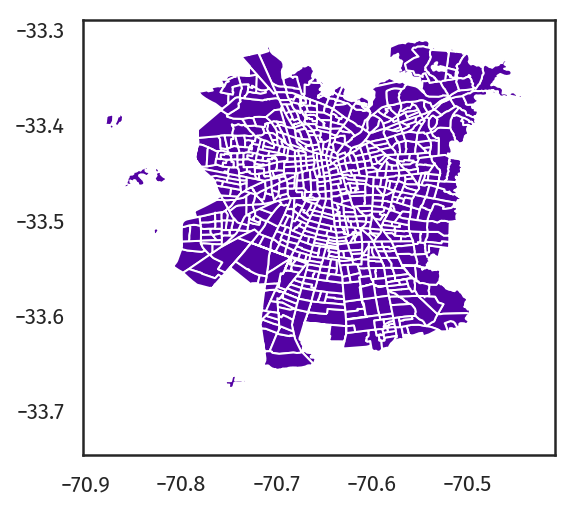

In [19]:
zonas_urbanas.plot()

In [20]:
zonas_urbanas = zonas_urbanas.set_index('ID')

In [21]:
viajes_persona.head()

,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,OrigenCoordX,...,IngresoFinal,TramoIngresoFinal,IngresoImputado,Factor_LaboralNormal,Factor_SabadoNormal,Factor_DomingoNormal,Factor_LaboralEstival,Factor_FindesemanaEstival,Factor,PesoLaboral
0,173431,17343102,1,Maipú,Maipú,Poniente,Poniente,400,407,335208.7188,...,0,0,0,142.3375,NaN,NaN,NaN,NaN,53.39174,142.337500
1,173431,17343102,1,Maipú,Maipú,Poniente,Poniente,407,400,338812.2813,...,0,0,0,142.3375,NaN,NaN,NaN,NaN,53.39174,142.337500
2,173441,17344101,2,Maipú,Las Condes,Poniente,Oriente,407,307,338536.4375,...,350000,2,0,112.9581,NaN,NaN,NaN,NaN,46.32137,127.328613
3,173441,17344101,2,Las Condes,Maipú,Oriente,Poniente,307,407,354267.3438,...,350000,2,0,112.9581,NaN,NaN,NaN,NaN,46.32137,127.328613
4,173441,17344103,2,Maipú,Ñuñoa,Poniente,Oriente,407,437,338536.4375,...,283883,2,1,103.5267,NaN,NaN,NaN,NaN,43.02566,116.697351


In [44]:
viajes_urbanos = viajes_persona[viajes_persona.ZonaOrigen.isin(zonas_urbanas.index) & 
                                viajes_persona.ZonaDestino.isin(zonas_urbanas.index)].copy()
viajes_urbanos.shape

(52113, 77)

## ¿Cómo se mueven los distintos grupos etáreos en la ciudad?

In [46]:
viajes_urbanos['RangoEtareo'] = pd.cut(2012 - viajes_urbanos.AnoNac, [0, 18, 30, 40, 60, 120], right=True)

In [47]:
viajes_urbanos['RangoEtareo'].value_counts()

(40, 60]     14552
(18, 30]     11523
(0, 18]      10118
(30, 40]      8450
(60, 120]     7267
Name: RangoEtareo, dtype: int64

In [56]:
viajes_urbanos.RangoEtareo.cat.categories

IntervalIndex([(0, 18], (18, 30], (30, 40], (40, 60], (60, 120]],
              closed='right',
              dtype='interval[int64]')

In [57]:
matrices_30 = (viajes_urbanos[pd.notnull(viajes_urbanos.PesoLaboral) & (viajes_urbanos.RangoEtareo.cat.codes == 2)]
 .groupby(['ZonaOrigen', 'ZonaDestino'])
 .agg(n_viajes=('PesoLaboral', 'sum'))
)

In [58]:
matrices_30

n_viajes
ZonaOrigen ZonaDestino            
1          5            113.892111
           12            99.704488
           14           291.173097
           18           130.308883
           20           231.851075
...                            ...
781        766          210.271328
           768          212.064245
           770          627.936776
           771          171.987181
           773          106.986500

[7031 rows x 1 columns]

In [59]:
centroids = zonas_urbanas.centroid
centroids.head()

ID
103    POINT (-70.65851 -33.55806)
104    POINT (-70.67185 -33.55424)
106    POINT (-70.68875 -33.56184)
115    POINT (-70.67869 -33.55099)
116    POINT (-70.66524 -33.55684)
dtype: geometry

In [60]:
node_positions = dict(zip(centroids.index, zip(centroids.x, centroids.y)))

In [ ]:
node_positions

In [68]:
matrices_30.n_viajes.describe()

count    7031.000000
mean      280.364212
std       337.294014
min         5.144286
25%        85.556938
50%       165.537386
75%       346.997579
max      5176.440639
Name: n_viajes, dtype: float64

In [100]:
graph_30 = nx.from_pandas_edgelist(matrices_30[(matrices_30.n_viajes >= matrices_30.n_viajes.quantile(0.95))].reset_index(), 
                                source='ZonaOrigen', target='ZonaDestino', 
                                edge_attr='n_viajes',
                                create_using=nx.DiGraph())

In [101]:
graph_30.number_of_nodes(), graph_30.number_of_edges()

(258, 352)

In [102]:
# from https://github.com/beyondbeneath/bezier-curved-edges-networkx
import bezier

def curved_edges(G, pos, dist_ratio=0.2, bezier_precision=20, polarity='random'):
    # Get nodes into np array
    edges = np.array(G.edges())
    l = edges.shape[0]

    if polarity == 'random':
        # Random polarity of curve
        rnd = np.where(np.random.randint(2, size=l)==0, -1, 1)
    else:
        # Create a fixed (hashed) polarity column in the case we use fixed polarity
        # This is useful, e.g., for animations
        rnd = np.where(np.mod(np.vectorize(hash)(edges[:,0])+np.vectorize(hash)(edges[:,1]),2)==0,-1,1)
    
    # Coordinates (x,y) of both nodes for each edge
    # e.g., https://stackoverflow.com/questions/16992713/translate-every-element-in-numpy-array-according-to-key
    # Note the np.vectorize method doesn't work for all node position dictionaries for some reason
    u, inv = np.unique(edges, return_inverse = True)
    coords = np.array([pos[x] for x in u])[inv].reshape([edges.shape[0], 2, edges.shape[1]])
    coords_node1 = coords[:,0,:]
    coords_node2 = coords[:,1,:]
    
    # Swap node1/node2 allocations to make sure the directionality works correctly
    should_swap = coords_node1[:,0] > coords_node2[:,0]
    coords_node1[should_swap], coords_node2[should_swap] = coords_node2[should_swap], coords_node1[should_swap]
    
    # Distance for control points
    dist = dist_ratio * np.sqrt(np.sum((coords_node1-coords_node2)**2, axis=1))

    # Gradients of line connecting node & perpendicular
    m1 = (coords_node2[:,1]-coords_node1[:,1])/(coords_node2[:,0]-coords_node1[:,0])
    m2 = -1/m1

    # Temporary points along the line which connects two nodes
    # e.g., https://math.stackexchange.com/questions/656500/given-a-point-slope-and-a-distance-along-that-slope-easily-find-a-second-p
    t1 = dist/np.sqrt(1+m1**2)
    v1 = np.array([np.ones(l),m1])
    coords_node1_displace = coords_node1 + (v1*t1).T
    coords_node2_displace = coords_node2 - (v1*t1).T

    # Control points, same distance but along perpendicular line
    # rnd gives the 'polarity' to determine which side of the line the curve should arc
    t2 = dist/np.sqrt(1+m2**2)
    v2 = np.array([np.ones(len(edges)),m2])
    coords_node1_ctrl = coords_node1_displace + (rnd*v2*t2).T
    coords_node2_ctrl = coords_node2_displace + (rnd*v2*t2).T

    # Combine all these four (x,y) columns into a 'node matrix'
    node_matrix = np.array([coords_node1, coords_node1_ctrl, coords_node2_ctrl, coords_node2])

    # Create the Bezier curves and store them in a list
    curveplots = []
    for i in range(l):
        nodes = node_matrix[:,i,:].T
        curveplots.append(bezier.Curve(nodes, degree=2).evaluate_multi(np.linspace(0,1,bezier_precision)).T)
      
    # Return an array of these curves
    curves = np.array(curveplots)
    return curves

In [103]:
curves = curved_edges(graph_30, node_positions)

/home/egraells/anaconda3/envs/azuki/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


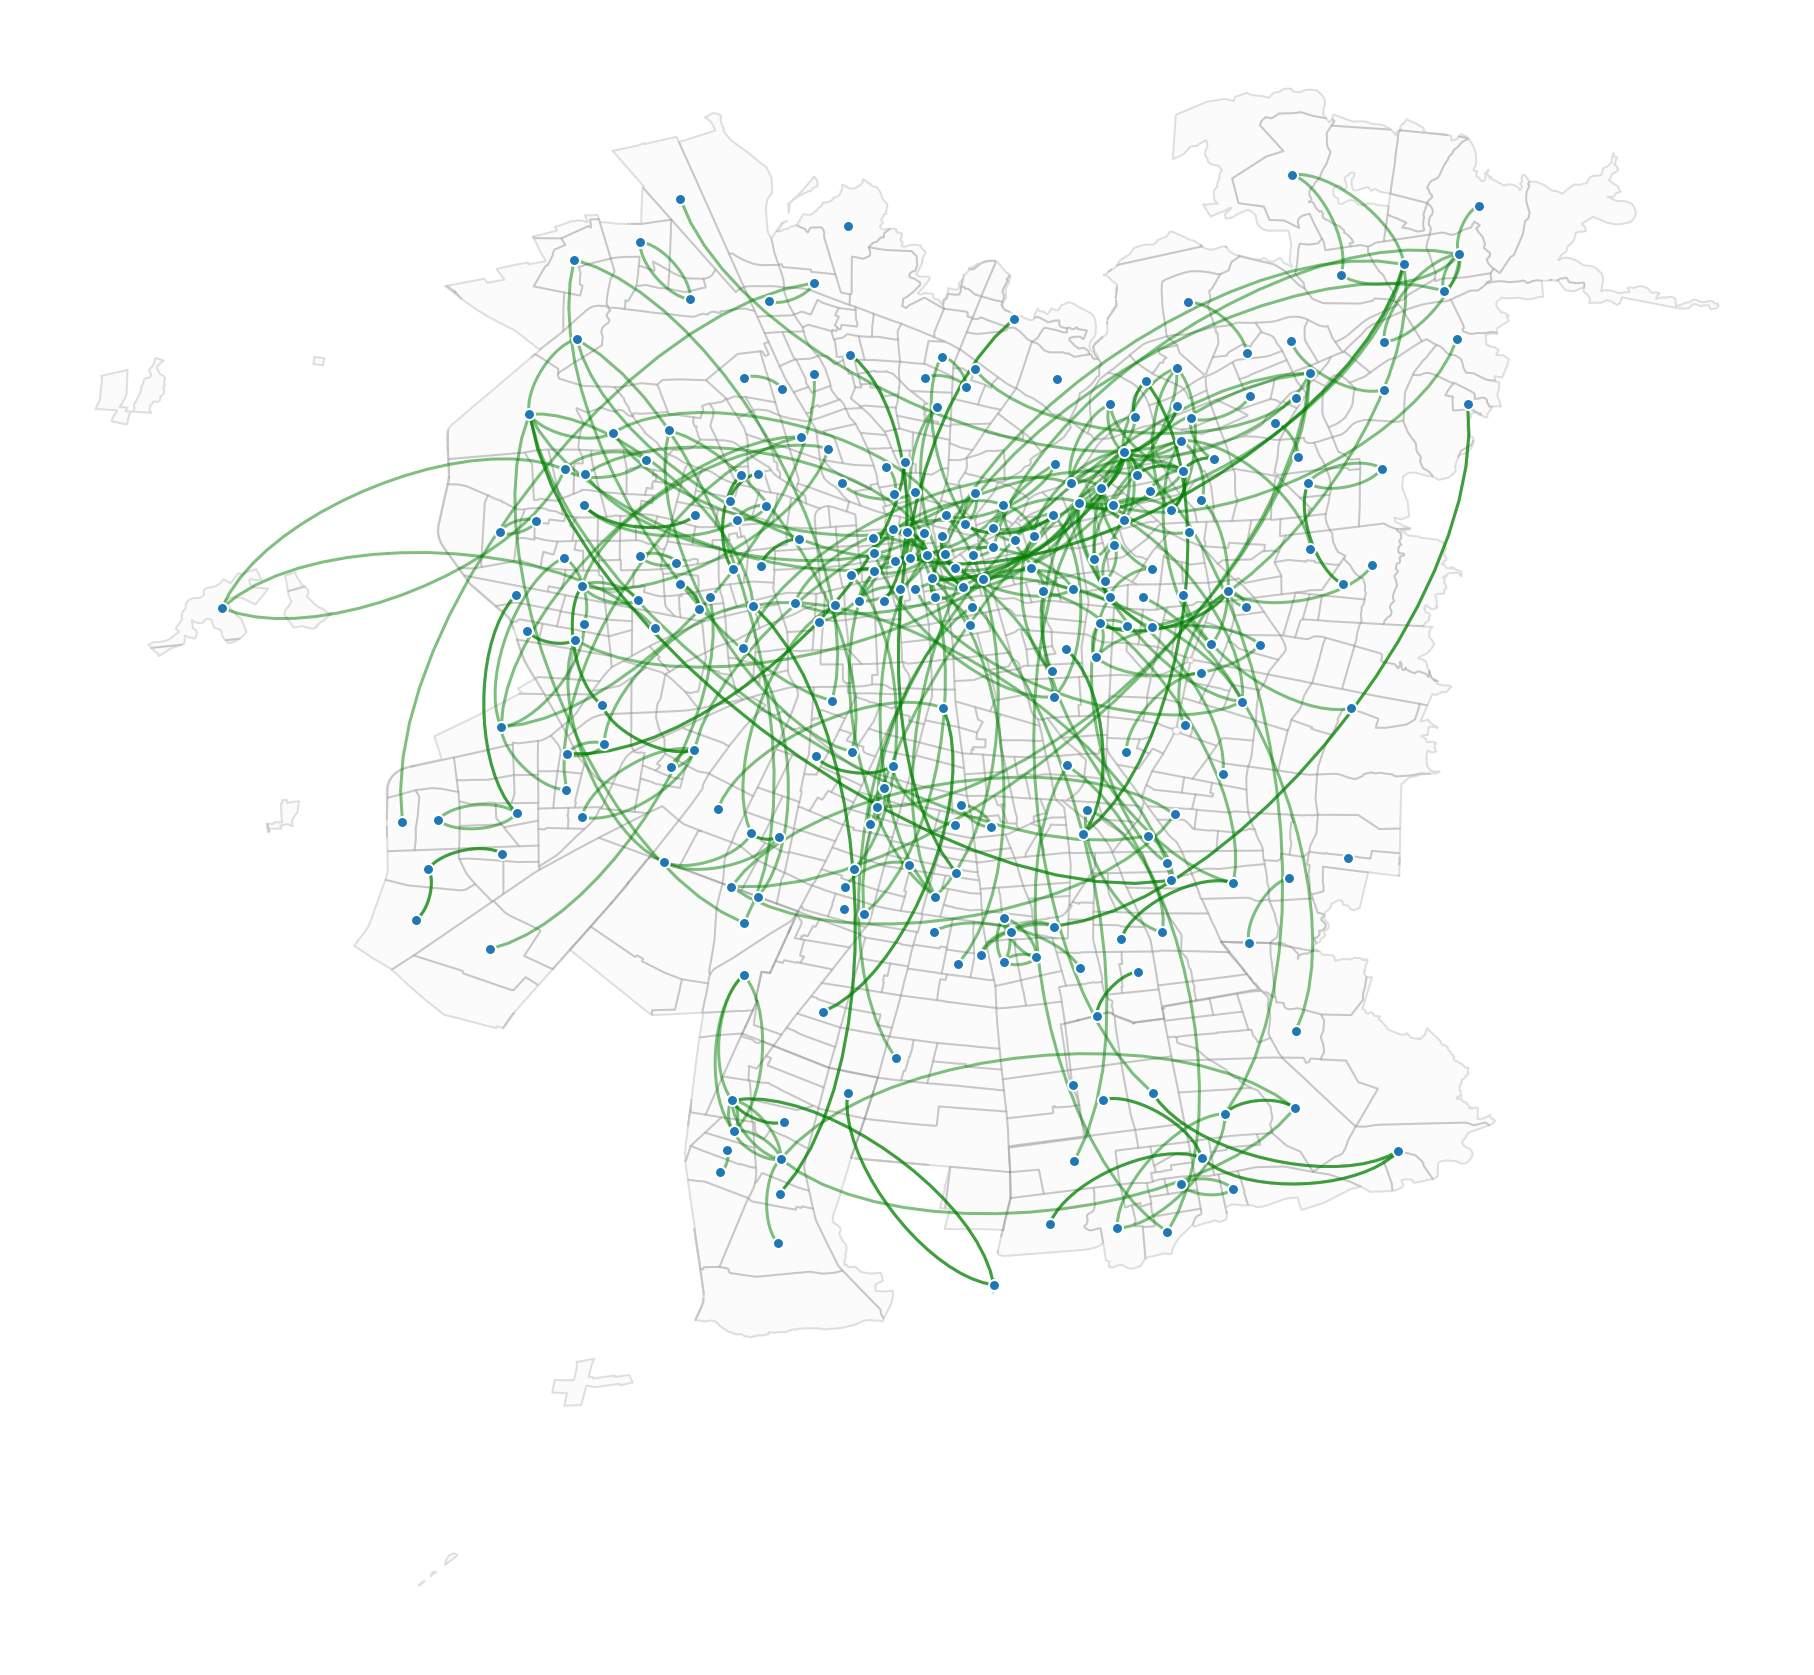

In [104]:
from matplotlib.collections import LineCollection

fig, ax = plt.subplots(1, 1, figsize=(16,16))

edges = LineCollection(curves, color='green', alpha=0.5)

zonas_urbanas.plot(ax=ax, facecolor='#efefef', edgecolor='#666666', alpha=0.2)
ax.add_collection(edges)
nx.draw_networkx_nodes(graph_30, ax=ax, pos=node_positions, node_size=30, edgecolors='white', linewidth=1, with_labels=False)

ax.set_axis_off()